## 1. Load Essential Libraries

In [29]:
import pandas as pd
import re
import time
import nltk

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
#from sklearn.naive_bayes import ComplementNB

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle
 
#import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import re as reg
from nltk.stem.isri import ISRIStemmer
import numpy as np

import warnings
warnings.filterwarnings("ignore")

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
st = ISRIStemmer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#pretrained_model='UBC-NLP/ARBERT'   #2 epochs is the best 73%
#pretrained_model='UBC-NLP/MARBERT'  # 70%
#pretrained_model='asafaya/bert-large-arabic' #memory error
#pretrained_model='asafaya/bert-medium-arabic'  #memory error
#pretrained_model='bashar-talafha/multi-dialect-bert-base-arabic'
pretrained_model="asafaya/bert-base-arabic"  #3 epochs is the best  76%
#pretrained_model="CAMeL-Lab/bert-base-camelbert-msa-sixteenth"  #69% ep=2
epoch_bert=1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Dataset

In [34]:

print("Start")

data = pd.read_excel("all_files_5th.xlsx")
df2 = pd.read_excel("d_7_1.xlsx")

data.sample(5)
len(data)

Start


115919

In [ ]:
#data=data[:20000]


############### To let Inaccurate=Fake News #############################
"""
lst=data['factual_tag']
lst2=['Fake News' if x=="Inaccurate" else x for x in lst ]
data['factual_tag']=lst2



lst=df2['factual_tag']
lst2=['Fake News' if x=="Inaccurate" else x for x in lst ]
df2['factual_tag']=lst2
"""

"""
############### To let Not Fake News=Neutral #############################
lst=data['factual_tag']
lst2=['Not Fake News' if x=="Neutral" else x for x in lst ]
data['factual_tag']=lst2

lst=df2['factual_tag']
lst2=['Not Fake News' if x=="Neutral" else x for x in lst ]
df2['factual_tag']=lst2
"""

 
############### To drop Inaccurate #############################
idx = data.index[data['factual_tag']=="Inaccurate"]
data = data.drop(idx, axis=0)
data= data.reset_index(drop=True)

idx = df2.index[df2['factual_tag']=="Inaccurate"]
df2 = df2.drop(idx, axis=0)
df2= df2.reset_index(drop=True)




############### To drop Neutral  #############################
idx = data.index[data['factual_tag']=="Neutral"]
data = data.drop(idx, axis=0)
data= data.reset_index(drop=True)

idx = df2.index[df2['factual_tag']=="Neutral"]
df2 = df2.drop(idx, axis=0)
df2= df2.reset_index(drop=True)
 


"""
############### To let Positive =Neutral #############################
lst=data['sentiment_tag']
lst2=['Positive' if x=="Neutral" else x for x in lst ]
data['sentiment_tag']=lst2

lst=df2['sentiment_tag']
lst2=['Positive' if x=="Neutral" else x for x in lst ]
df2['sentiment_tag']=lst2
##########################################



############### To let spam =Fake News  #############################
lst=data['factual_tag']
lst_spam=data['Spam']
lst2=['Fake News' if lst_spam[i]==1 else lst[i] for i in range(len(lst)) ]
data['factual_tag']=lst2

""" 

'''
['body', 'category', 'post_language', 'owner_user_id', 'amount_likes',
       'amount_comments', 'social_network_id', 'social_user_id',
       'social_post_id', 'amount_comments', 'amount_likes',
       'shared_posts_count', 'shared_posts_count_direct', 'user_id',
       'last_refresh_comments_at', 'reply_data', 'factual_tag',
       'emotional_tag', 'sentiment_tag', 'category_tag', 'general_tags'],
      dtype='object')
'''
###########################################################################################################


data=data[['body','factual_tag','post_language']]
list1=data['body']
list2=data['factual_tag']
list3=data['post_language']
list2=[0  if x=='Not Fake News' else 1 for x in list2]
list1=[x[:1000] if type(x)==str else x for x in list1]
lis_tb=[(list1[i],list2[i],list3[i])  for i in range(len(list1))]
data=pd.DataFrame(lis_tb, columns =['body','factual_tag','post_language'])


df2=df2[['body','factual_tag','post_language']]
list1=df2['body']
list2=df2['factual_tag']
list3=df2['post_language']
list2=[0  if x=='Not Fake News' else 1 for x in list2]
list1=[x[:1000] if type(x)==str else x for x in list1]
lis_tb=[(list1[i],list2[i],list3[i])  for i in range(len(list1))]
df2=pd.DataFrame(lis_tb, columns =['body','factual_tag','post_language'])

### to select arabic (L='ar') or English (L='en') or both (L='all')
L='ar' 
n=500000  # The number of the samples, the best is 500000  for en  and  400000 for  ar
th=0       # threshold to delete small posts which has length<th
text='body'#'text'
tag='factual_tag'#
#tag='sentiment_tag'#
#tag='emotional_tag'#'tag'
#tag="Formal"
#tag="Spam"
#tag="Opinion"
#tag="Hate Speech"
#tag="Sarcasm"
#tag="Congratulation"
Language='post_language'#'Language'
embedding=0#True
prob=0
################################



def normalize_arabic(text):  ### This method is to normalize the Arabic characters 
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text   



## To find arabic Tashkeel
arabic_diacritics = re.compile("""  
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def modify_post(input_str):   ### This method is to perform the preprocessing operations 
    input_str = re.sub(r'http\S+', '', input_str)  #remove URL
    input_str = re.sub(r'[^\w\s]','',input_str)  #remove punctuation 
    input_str = re.sub('_+' , ' ', input_str)  #remove underscore 
    input_str = re.sub(r'\s+', ' ', input_str)   #remove newLine
    input_str = re.sub(arabic_diacritics, '', input_str)   #Tashkeel
    input_str = normalize_arabic(input_str)      # Normalization
    input_str= re.sub('[0-9]+', 'ارقام', input_str)   #Replace digits  
    
    #input_str= re.sub(' ال', ' ', input_str)      ## remove AL   
    #input_str= re.sub(' وال', ' ', input_str)     ## remove wAL 
    #input_str= re.sub(' فال', ' ', input_str)     ## remove fAL 

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('arabic')) + r')\b\s*')  # NLTK stop
    #input_str=pattern.sub(' ',input_str) # remove stop words
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')  # NLTK stop
    #input_str=pattern.sub(' ',input_str) # remove stop words

    pattern=reg.compile(r"(.)\1{1,}",reg.DOTALL)
    input_str=pattern.sub(r"\1",input_str)   #remove duplicate ch
    
 
    
    #input_str = input_str.lower()         #Lower
    #input_str = ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(input_str)])  # lemmatize
    #input_str = ' '.join([ps.stem(w) for w in nltk.word_tokenize(input_str)])   #Stem English
    #input_str = ' '.join([st.stem(w) for w in nltk.word_tokenize(input_str)])   #Stem Arabic
    
    #input_str=translitArabic(input_str)
    
    return input_str

import  random
def oversample(df, m):
    x=len(df)
    #print(x)
    df2=df.copy()
    while len(df2)<m:
        df2=pd.concat([df2,df] , axis=0, ignore_index=True)
        
    y=len(df2)
    #print(y)
    for i in range(x,y):
        v1=random.randint(1,x-1)
        v2=random.randint(1,x-1)
        v5=random.randint(1,x-1)
        #print(i,"   ",v1,"    ",v2)
        v3=len(df2[text][v1])
        v4=len(df2[text][v2])
        #df2[text][i]=df2[text][v1][:int(v3/2)]+df2[text][v2][int(v4/2):]
        df2[text][i]=df2[text][v1]+df2[text][v2]+df2[text][v5]

    #print("###############",len(df2))
    return df2

def do_over_sample(df, m):  ### This method is to return Oversampinge from smaell categories 
    d1=pd.DataFrame()
    set_tag=set(data[tag])
    for x in set_tag:
        t1=df[df[tag]==x]
        if len(t1)<=m: t1=oversample(t1, m)
        d1=pd.concat([d1,t1], axis=0, ignore_index=True)
    return d1

data=data[data[text].map(type) == str]      ### to convert all post body  to sting, this is necessary for blank posts
data[text] = data[text].str.lower()  ### to conver all ch to lower case
 

print("The number of all records is: ",len(data))
data_ar=data[data[Language]=='ar']
print("The number of Arabic records is: ", len(data_ar))
data_en=data[data[Language]=='en']
print("The number of English records is: ", len(data_en))
#print()


data=data[data[Language]==L]
print("Preprocessing ..........")
#data_ar=sample_story(data_ar,2)
data=data[data[text].map(len)>th]
#data_ar=cat_sample(data_ar,n)
#data= do_over_sample(data, 500)
data= data.reset_index(drop=True)
#data2=data.copy()
data[text]=data[text].apply(modify_post)



df2=df2[df2[text].map(type) == str]      ### to convert all post body  to sting, this is necessary for blank posts
df2[text] = df2[text].str.lower()  ### to conver all ch to lower case
df2=df2[df2[Language]==L]
print("Preprocessing ..........")
#data_ar=sample_story(data_ar,2)
df2=df2[df2[text].map(len)>th]
#data_ar=cat_sample(data_ar,n)
#data= do_over_sample(data, 500)
df2= df2.reset_index(drop=True)
#data2=data.copy()
df2[text]=df2[text].apply(modify_post)


data.sample(5)

The number of all records is:  75348
The number of Arabic records is:  35937
The number of English records is:  39408
Preprocessing ..........
Preprocessing ..........


,body,factual_tag,post_language
19794,انا رافع رايات عشقي بدور ع الي مش ملقي يحارب ك...,0,ar
7770,العرض المدني في عيد الاستقلال امام افواج البنا...,0,ar
3496,صباح الخير اتمني التوفيق لجميع الفرق السعوديه ...,0,ar
24008,يسر جمعيه الطلبه العمانين بمدينه جلاسجو تهنءه ...,0,ar
29210,ناءج الفحوصات ليس هناك اي اصابه كورونا من بين ...,0,ar


We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [ ]:
from sklearn.model_selection import train_test_split
X=data.body.values
y=data.factual_tag.values
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size = 0.001, random_state=0)
#train_test_split(X, y, test_size=0.1, random_state=2020)

### 2.3. Load Test Data
The test data contains 4555 examples with no label. About 300 examples are non-complaining tweets. Our task is to identify their `id` and examine manually whether our results are correct.

In [ ]:
# Load test data
test_data = df2

# Keep important columns
test_data = test_data[text]

# Display 5 samples from the test data
test_data.sample(5)

632     نعود بحذر ملتزمين بالاجراءات الاحترازيه الصحيه...
1417    رءيس الوزراء الفلسطيني د محمد اشتيه اطلب من اص...
373     محكمه استءناف شبين الكوم تءيد الحكم علي المتهم...
1458    شاهدبرنامج من دمشق عنوان الحلقه د رمضان شلحرجل...
127                          حرق مدينه ولا كسر خاطر نصيحه
Name: body, dtype: object

## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


# Baseline: TF-IDF + Naive Bayes Classifier

In [ ]:
 
import nltk
# Uncomment to download "stopwords"
#nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
  
    #Lowercase the sentence
    # Change "'t" to "not"
    # Remove "@name"
    # Isolate and remove punctuations except "?"
    # Remove other special characters
    # Remove stop words except "not" and "can"
    # Remove trailing whitespace
 
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    """
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('arabic')
                  or word in ['not', 'can']])
    """
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s
 

### TF-IDF Vectorizer

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 11.5 s, sys: 354 ms, total: 11.8 s
Wall time: 11.8 s


## Train Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.0


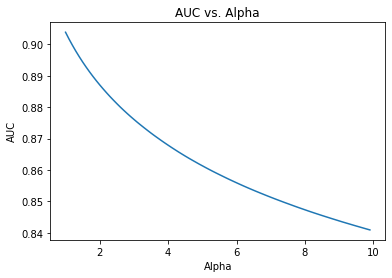

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9286
Accuracy: 83.33%


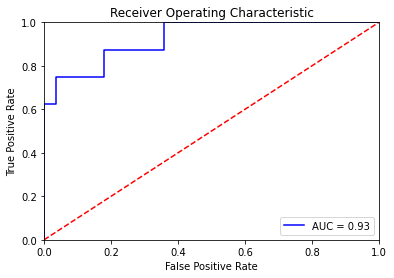

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

# Fine-tuning BERT

## 1. Install the Hugging Face Library

In [ ]:
!pip install transformers

## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [ ]:
from transformers import BertTokenizer


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(pretrained_model, do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.body.values, df2.body.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  307


Now let's tokenize our data.

In [ ]:
# Specify `MAX_LEN`
MAX_LEN =max_len   # 64

#X = data.body.values

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
#print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Token IDs:  [2, 15722, 1917, 19211, 2337, 76, 22796, 1047, 3046, 8040, 9244, 4076, 6293, 9244, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(np.array(y_train))
val_labels = torch.tensor(np.array(y_val))

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Train Our Model

### Create BertClassifier

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(pretrained_model)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        #print(logits)
        return logits

CPU times: user 23.7 ms, sys: 2.57 ms, total: 26.2 ms
Wall time: 27.2 ms


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            #print(type(logits))
            #print(len(logits))
            #print(logits)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=epoch_bert)
train(bert_classifier, train_dataloader, val_dataloader, epochs=epoch_bert, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.438957   |     -      |     -     |   20.06  
   1    |   40    |   0.297225   |     -      |     -     |   19.08  
   1    |   60    |   0.272035   |     -      |     -     |   19.03  
   1    |   80    |   0.226807   |     -      |     -     |   19.05  
   1    |   100   |   0.253033   |     -      |     -     |   19.07  
   1    |   120   |   0.256002   |     -      |     -     |   19.06  
   1    |   140   |   0.169863   |     -      |     -     |   19.05  
   1    |   160   |   0.222502   |     -      |     -     |   19.04  
   1    |   180   |   0.208579   |     -      |     -     |   19.05  
   1    |   200   |   0.222163   |     -      |     -     |   19.05  
   1    |   220   |   0.251849   |     -      |     -     |   19.04  
   1    |   240   |   0.194442   |     -      |     -     |   19.03  



### Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9821
Accuracy: 94.44%


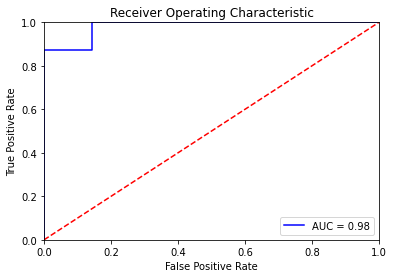

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
predictions=[0 if x[0]>x[1] else 1 for x in probs]

print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.88      0.88      0.88         8

    accuracy                           0.94        36
   macro avg       0.92      0.92      0.92        36
weighted avg       0.94      0.94      0.94        36



### Train Our Model on the Entire Training Data

## Predictions on Test Set

### Data Preparation

In [ ]:
test_data.sample(5)

2295    اشكال تسريحات غرف نوم ارقامتسريحات غرف نوم كلا...
1421    شركه تسليك المجاري بالقطيف ارقام افضل شركات تس...
1057                      عيون باز باز يجمعنا انا علي باز
211     المقطع ده مش بيثبت غير انه الراجل الي في الفيد...
2192    عاجل مثل حركه حماس في ايران خالد القدومي لن يك...
Name: body, dtype: object

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(df2.body)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### 4.2. Predictions

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)


In [ ]:


# Get predictions from the probabilities
threshold = 0.5
preds2 = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds2.sum())

Number of tweets predicted non-negative:  113


In [ ]:
predictions=[0 if x[0]>x[1] else 1 for x in probs]

print(classification_report(df2.factual_tag.values,predictions))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2298
           1       0.81      0.27      0.41       337

    accuracy                           0.90      2635
   macro avg       0.86      0.63      0.68      2635
weighted avg       0.89      0.90      0.88      2635

